C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\1702610762.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rush_distance_summary = game_data_rushing.groupby('rush_distance_category').agg({
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\1702610762.py:99: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_data_rushing['x'] = game_data_rushing['run_location'].replace({'left': -1, 'middle': 0, 'right': 1})
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_14512\1702610762.py:195: FutureWarning: 

Passing `palette` without assigning `hue`

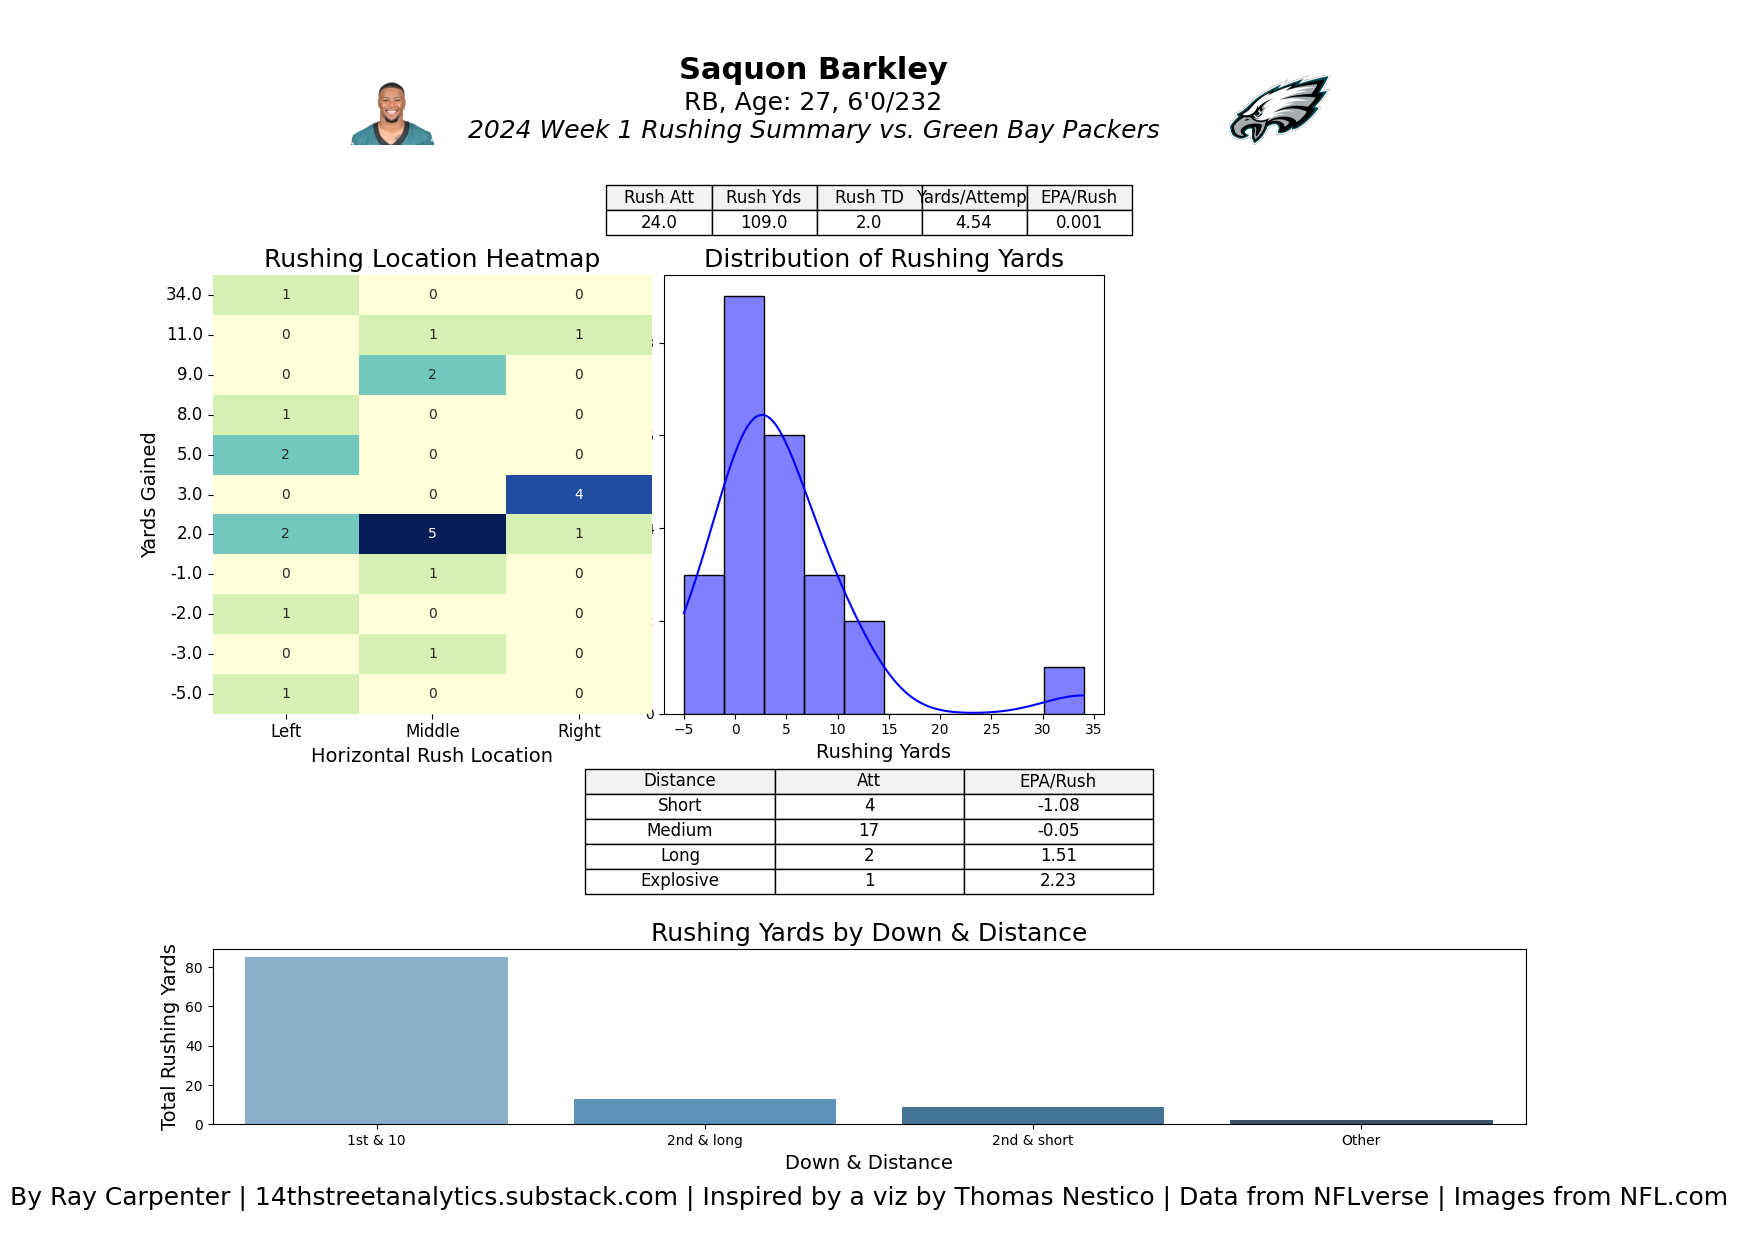

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from PIL import Image

# Define the year and load the data
YEAR = 2024
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Function to get an image from ESPN based on player_id
def get_espn_headshot(player_id: str):
    url = f'https://a.espncdn.com/combiner/i?img=/i/headshots/nfl/players/full/{player_id}.png'
    response = requests.get(url)
    
    if response.status_code == 200:
        return Image.open(BytesIO(response.content))
    else:
        print(f"Could not retrieve headshot for player {player_id}")
        return None

def player_headshot(player_id: str, ax: plt.Axes):
    headshot = get_espn_headshot(player_id)
    
    if headshot:
        ax.imshow(headshot)
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No Image', ha='center', va='center', fontsize=12)
        ax.axis('off')

# Manually set player ID for Saquon Barkley
player_id = '3929630'
headshot = get_espn_headshot(player_id)

# Manual filters for team (Giants) and game
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]

# Filter rushing plays for Saquon Barkley
rushing_plays = filtered_df[filtered_df['rusher_player_name'] == 'S.Barkley']

# Filter game data by game ID
game_data_rushing = rushing_plays[rushing_plays['game_id'] == '2024_01_GB_PHI']

# Calculate cumulative rushing statistics
total_rushing_epa = game_data_rushing['epa'].sum()
rush_attempts = game_data_rushing['rush_attempt'].sum()
rush_yards = game_data_rushing['rushing_yards'].sum()
rush_touchdowns = game_data_rushing['rush_touchdown'].sum()

if rush_attempts == 0:
    rush_yards = 0
    rush_touchdowns = 0

yards_per_attempt = round(rush_yards / rush_attempts, 2) if rush_attempts > 0 else 0
epa_per_rush = round(total_rushing_epa / rush_attempts, 3) if rush_attempts > 0 else 0

summary_table = {
    'Rush Att': [int(rush_attempts)],        
    'Rush Yds': [int(rush_yards)],           
    'Rush TD': [int(rush_touchdowns)],       
    'Yards/Attempt': [yards_per_attempt],
    'EPA/Rush': [epa_per_rush]
}

summary_df = pd.DataFrame.from_dict(summary_table)

# Create bins for rush distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Short', 'Medium', 'Long', 'Explosive']
game_data_rushing['rush_distance_category'] = pd.cut(game_data_rushing['rushing_yards'], bins=bins, labels=labels)

rush_distance_summary = game_data_rushing.groupby('rush_distance_category').agg({
    'rush_attempt': 'sum',
    'epa': 'sum'
}).reset_index()

rush_distance_summary['EPA/Rush'] = (rush_distance_summary['epa'] / rush_distance_summary['rush_attempt']).round(2)

# Convert categorical column to string type
rush_distance_summary['rush_distance_category'] = rush_distance_summary['rush_distance_category'].astype(str)

# Now fill missing values
rush_distance_summary.fillna(0, inplace=True)

rush_distance_summary = rush_distance_summary[['rush_distance_category', 'rush_attempt', 'EPA/Rush']]
rush_distance_summary.columns = ['Distance', 'Att', 'EPA/Rush']
rush_distance_summary['Att'] = rush_distance_summary['Att'].astype(int)

# Map run location to numerical values for heatmap
game_data_rushing['x'] = game_data_rushing['run_location'].replace({'left': -1, 'middle': 0, 'right': 1})
game_data_rushing['y'] = game_data_rushing['rushing_yards']

# Load the Giants logo
logo_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/philadelphia-eagles-logo.png'  # Manually find logo path
logo = Image.open(logo_path)

# Define bins for down and distance categories using the correct 'ydstogo' column
def categorize_down_distance(row):
    if row['down'] == 1 and row['ydstogo'] == 10:
        return '1st & 10'
    elif row['down'] == 2 and row['ydstogo'] <= 3:
        return '2nd & short'
    elif row['down'] == 2 and row['ydstogo'] > 3:
        return '2nd & long'
    elif row['down'] == 3 and row['ydstogo'] <= 3:
        return '3rd & short'
    elif row['down'] == 3 and row['ydstogo'] > 3:
        return '3rd & long'
    else:
        return 'Other'

# Apply the function to create a new column
game_data_rushing['down_distance_category'] = game_data_rushing.apply(categorize_down_distance, axis=1)

# Group and summarize rushing yards by down and distance category
rushing_by_down_distance = game_data_rushing.groupby('down_distance_category').agg({
    'rush_attempt': 'sum',
    'rushing_yards': 'sum',
    'epa': 'sum'
}).reset_index()

# Calculate EPA/Rush for each down and distance category
rushing_by_down_distance['EPA/Rush'] = (rushing_by_down_distance['epa'] / rushing_by_down_distance['rush_attempt']).round(2)

def rb_dashboard(game_data_rushing: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, rush_distance_summary: pd.DataFrame, rushing_by_down_distance: pd.DataFrame, save_path: str = None):
    fig = plt.figure(figsize=(18, 16))  
    gs = gridspec.GridSpec(7, 20, height_ratios=[2, 4, 4, 25, 10, 10, 5], width_ratios=[1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1])

    ax_headshot = fig.add_subplot(gs[1, 2:4])
    ax_bio = fig.add_subplot(gs[1, 5:13])
    ax_logo = fig.add_subplot(gs[1, 14:16])
    ax_summary_table = fig.add_subplot(gs[2, 1:19])
    ax_yards_dist = fig.add_subplot(gs[3, 7:13])
    ax_rush_distance = fig.add_subplot(gs[4, 1:19])
    ax_heatmap = fig.add_subplot(gs[3, 1:7])
    ax_down_distance = fig.add_subplot(gs[5, 1:19])

    ax_footer = fig.add_subplot(gs[-1, 1:19])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    ax_footer.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    player_headshot(player_id, ax_headshot)
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    ax_bio.text(0.5, 0.95, 'Saquon Barkley', fontsize=22, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.50, 'RB, Age: 27, 6\'0/232', fontsize=18, ha='center')
    ax_bio.text(0.5, 0.1, '2024 Week 1 Rushing Summary vs. Green Bay Packers', fontsize=18, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center', colColours=['#f2f2f2'] * len(summary_df.columns), colWidths=[0.1] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(0.8, 1.5)

    sns.histplot(game_data_rushing['rushing_yards'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Rushing Yards', fontdict={'size': 14})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 14})
    ax_yards_dist.set_title('Distribution of Rushing Yards', fontdict={'size': 18})

    ax_rush_distance.axis('off')
    rush_distance_table = ax_rush_distance.table(cellText=rush_distance_summary.values, colLabels=rush_distance_summary.columns, cellLoc='center', loc='center', colColours=['#f2f2f2'] * len(rush_distance_summary.columns), colWidths=[0.18] * len(rush_distance_summary.columns))
    rush_distance_table.auto_set_font_size(False)
    rush_distance_table.set_fontsize(12)
    rush_distance_table.scale(.8, 1.5)

    # Create a heatmap for rushing location
    heatmap_data = game_data_rushing.pivot_table(index='y', columns='x', aggfunc='size', fill_value=0)
    sns.heatmap(heatmap_data, cmap='YlGnBu', ax=ax_heatmap, annot=True, cbar=False)
    ax_heatmap.set_title('Rushing Location Heatmap', fontsize=18)
    ax_heatmap.set_xlabel('Horizontal Rush Location', fontsize=14)
    ax_heatmap.set_ylabel('Yards Gained', fontsize=14)
    ax_heatmap.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_heatmap.set_yticklabels(heatmap_data.index, fontsize=12)

    # Flip the Y-axis
    ax_heatmap.invert_yaxis()
    ax_heatmap.tick_params(axis='y', labelrotation=0)

    # Add the new down and distance bar chart
    sns.barplot(x='down_distance_category', y='rushing_yards', data=rushing_by_down_distance, ax=ax_down_distance, palette='Blues_d')
    ax_down_distance.set_title('Rushing Yards by Down & Distance', fontsize=18)
    ax_down_distance.set_xlabel('Down & Distance', fontsize=14)
    ax_down_distance.set_ylabel('Total Rushing Yards', fontsize=14)

    ax_footer.text(0.5, 0.5, 'By Ray Carpenter | 14thstreetanalytics.substack.com | Inspired by a viz by Thomas Nestico | Data from NFLverse | Images from NFL.com', ha='center', va='center', fontsize=18)

    plt.tight_layout(pad=1.5)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

save_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/rb_dashboard.png'

rb_dashboard(game_data_rushing, headshot, logo, summary_df, rush_distance_summary, rushing_by_down_distance, save_path=save_path)



In [15]:
data.head(10)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack